## Some simple F0 estimation methods, implemented by https://gist.github.com/endolith/255291

In [1]:
from __future__ import division
from numpy import polyfit, arange

def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
   
    f is a vector and x is an index for that vector.
   
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
   
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
   
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
   
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
   
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)


def parabolic_polyfit(f, x, n):
    """Use the built-in polyfit() function to find the peak of a parabola
    
    f is a vector and x is an index for that vector.
    
    n is the number of samples of the curve used to fit the parabola.
    """    
    a, b, c = polyfit(arange(x-n//2, x+n//2+1), f[x-n//2:x+n//2+1], 2)
    xv = -0.5 * b/a
    yv = a * xv**2 + b * xv + c
    return (xv, yv)


if __name__=="__main__":
    from numpy import argmax
    import matplotlib.pyplot as plt
    
    y = [2, 1, 4, 8, 11, 10, 7, 3, 1, 1]
    
    xm, ym = argmax(y), y[argmax(y)]
    xp, yp = parabolic(y, argmax(y))
    
    plot = plt.plot(y)
    plt.hold(True)
    plt.plot(xm, ym, 'o', color='silver')
    plt.plot(xp, yp, 'o', color='blue')
    plt.title('silver = max, blue = estimated max')


/Users/jcdevaney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/jcdevaney/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/jcdevaney/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


In [2]:
from __future__ import division
from numpy.fft import rfft
from numpy import argmax, mean, diff, log
from matplotlib.mlab import find
from scipy.signal import blackmanharris, fftconvolve
from time import time
import sys
try:
    import soundfile as sf
except ImportError:
    from scikits.audiolab import flacread

In [3]:
def freq_from_crossings(sig, fs):
    """
    Estimate frequency by counting zero crossings
    """
    # Find all indices right before a rising-edge zero crossing
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))

    # Naive (Measures 1000.185 Hz for 1000 Hz, for instance)
    # crossings = indices

    # More accurate, using linear interpolation to find intersample
    # zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]

    # Some other interpolation based on neighboring points might be better.
    # Spline, cubic, whatever

    return fs / mean(diff(crossings))

In [4]:
def freq_from_fft(sig, fs):
    """
    Estimate frequency from peak of FFT
    """
    # Compute Fourier transform of windowed signal
    windowed = sig * blackmanharris(len(sig))
    f = rfft(windowed)

    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f))  # Just use this for less-accurate, naive version
    true_i = parabolic(log(abs(f)), i)[0]

    # Convert to equivalent frequency
    return fs * true_i / len(windowed)

In [5]:
def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """
    # Calculate autocorrelation (same thing as convolution, but with
    # one input reversed in time), and throw away the negative lags
    corr = fftconvolve(sig, sig[::-1], mode='full')
    corr = corr[len(corr)//2:]

    # Find the first low point
    d = diff(corr)
    start = find(d > 0)[0]

    # Find the next peak after the low point (other than 0 lag).  This bit is
    # not reliable for long signals, due to the desired peak occurring between
    # samples, and other peaks appearing higher.
    # Should use a weighting function to de-emphasize the peaks at longer lags.
    peak = argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return fs / px

In [30]:
#filename = sys.argv[1]
filename='avmA.wav'

print('Reading file "%s"\n' % filename)
try:
    signal, fs = sf.read(filename)
except NameError:
    signal, fs, enc = flacread(filename)

print('Calculating frequency from FFT:'),
start_time = time()
print('%f Hz' % freq_from_fft(signal, fs))
print('Time elapsed: %.3f s\n' % (time() - start_time))

print('Calculating frequency from zero crossings:'),
start_time = time()
print('%f Hz' % freq_from_crossings(signal, fs))
print('Time elapsed: %.3f s\n' % (time() - start_time))

print('Calculating frequency from autocorrelation:'),
start_time = time()
print('%f Hz' % freq_from_autocorr(signal, fs))
print('Time elapsed: %.3f s\n' % (time() - start_time))

Reading file "avmA.wav"

Calculating frequency from FFT:
895.650467 Hz
Time elapsed: 0.044 s

Calculating frequency from zero crossings:
910.090770 Hz
Time elapsed: 0.013 s

Calculating frequency from autocorrelation:
456.347687 Hz
Time elapsed: 0.024 s



## YIN algorithm, implemented in Aubio: https://aubio.org/

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import aubio

In [27]:
# YIN pitches
filename='avmA.wav'
downsample = 1
samplerate = 0
win_s = 1764 // downsample # fft size
hop_s = 441 // downsample # hop size
s = aubio.source(filename, samplerate, hop_s)
samplerate = s.samplerate
tolerance = 0.1

start_time = time()
pitch_o = aubio.pitch("yin", win_s, hop_s, samplerate) 
#pitch_o.set_unit("midi")
pitch_o.set_tolerance(tolerance)

pitchesYIN = []
confidences = [] 
total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    pitch = int(round(pitch))
    confidence = pitch_o.get_confidence()
    pitchesYIN += [pitch]
    confidences += [confidence]
    total_frames += read
    if read < hop_s:
         break        
stop_time = time()            

In [28]:
print('Calculating frequency from YIN:'),
print('%f Hz' % mean(pitchesYIN))
print('Time elapsed: %.3f s\n' % (stop_time - start_time))

Calculating frequency from YIN:
453.268966 Hz
Time elapsed: 0.042 s



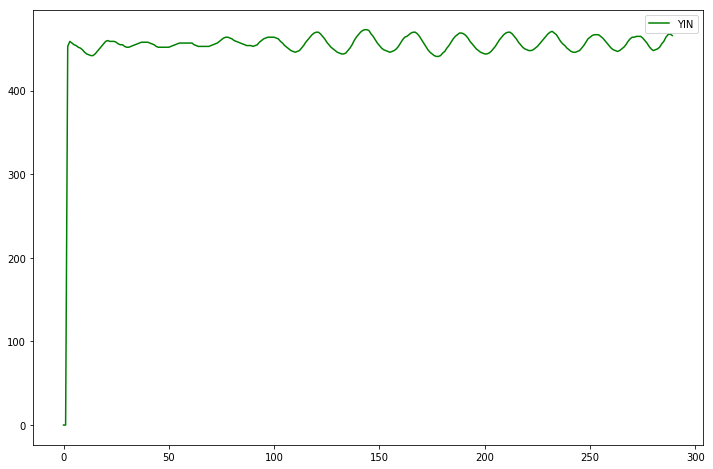

In [29]:
fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 8))
ax1.plot(np.asarray(pitchesYIN), label='YIN', color='green')
ax1.legend(loc="upper right")